In [1]:
import warnings
warnings.filterwarnings('ignore')

import os

ctrl_folder = r'D:\DL\data_train'
spr_folder = r'D:\DL\data_spread'

suffix = 'grb2'
files = os.listdir(ctrl_folder)
files_000 = [f for f in files if f.endswith('_f000.grb2')]
files_006 = [f for f in files if f.endswith('_f006.grb2')]
file_ctrl_00 = [os.path.join(ctrl_folder, name) for name in files_000]
file_ctrl_06 = [os.path.join(ctrl_folder, name) for name in files_006]
# print(file_ctrl_00)

files = os.listdir(spr_folder)
file_spr = [f for f in files if f.endswith(suffix)]
file_spr = [os.path.join(spr_folder, name) for name in file_spr]
# print(file_spr)

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
print(device)

cuda


In [2]:
import torch
import numpy as np
from grbdata import grbdata
from tsf2sfm import spharm_transform, spectral_to_grid
from torch.utils.data import Dataset

class WeatherDataset(Dataset):
    def __init__(self, ctrl_filepaths_00, ctrl_filepaths_06, spread_filepaths, layer, X_mean=None, X_std=None, Y_mean=None, Y_std=None):
        assert len(ctrl_filepaths_06) == len(spread_filepaths), "文件数量不一致"
        self.ctrl_filepaths_00 = ctrl_filepaths_00
        self.ctrl_filepaths_06 = ctrl_filepaths_06
        self.spread_filepaths = spread_filepaths
        self.layer = layer
        self.X_mean = X_mean
        self.X_std = X_std
        self.Y_mean = Y_mean
        self.Y_std = Y_std

        # 控制变量顺序（不包含lon和lat，因为spharm_transform会删除它们）
        self.ctrl_vars = ['gh','t','r','u','v',
                          'gh_diff','t_diff','r_diff','u_diff','v_diff',
                          'gh_grad','t_grad','r_grad','u_grad','v_grad',
                          'div_ctrl','vor_ctrl']
        self.spread_vars = ['gh', 't', 'r', 'u', 'v']

    def __len__(self):
        return len(self.ctrl_filepaths_00)

    def __getitem__(self, idx):
        ctrl_path_00 = self.ctrl_filepaths_00[idx]
        ctrl_path_06 = self.ctrl_filepaths_06[idx]
        spread_path = self.spread_filepaths[idx]

        ctrl_data, spread_data = grbdata(ctrl_path_00, ctrl_path_06, spread_path, self.layer, zoomin=1, ds=1)
        # 对数据进行球谐变换
        ctrl_data, spread_data = spharm_transform(ctrl_data), spharm_transform(spread_data)

        # 安全地构建数组，只使用存在的变量
        try:
            X = np.stack([ctrl_data[k] for k in self.ctrl_vars], axis=0)
            Y = np.stack([spread_data[k] for k in self.spread_vars], axis=0)
        except KeyError as e:
            print(f"缺少变量 {e}")
            print(f"ctrl_data可用变量: {list(ctrl_data.keys())}")
            print(f"spread_data可用变量: {list(spread_data.keys())}")
            raise
        
        # print(X.shape, Y.shape)
        
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)



In [3]:
dataset = WeatherDataset(file_ctrl_00, file_ctrl_06, file_spr, layer=500)
# 获取第一个 batch
data_iter = iter(dataset)
X_batch, Y_batch = next(data_iter)
print(f"Batch: X.shape = {X_batch.shape}, Y.shape = {Y_batch.shape}")


Batch: X.shape = torch.Size([17, 16471]), Y.shape = torch.Size([5, 16471])


In [4]:
import torch.nn as nn
class SphericalHarmonics1DCNN(nn.Module):
    def __init__(self, input_vars=17, output_vars=5, sph_coeffs=16471):
        super().__init__()
        
        # 1D卷积处理球谐系数维度
        self.conv_layers = nn.Sequential(
            nn.Conv1d(input_vars, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, output_vars, kernel_size=5, padding=2)
        )
        
    def forward(self, x):
        # x shape: (batch_size, 17, 16471)
        x = self.conv_layers(x)
        # output shape: (batch_size, 5, 16471)
        return x


In [5]:
import torch.optim as optim

def train_model(model, train_loader, val_loader, num_epochs=100, device='cuda'):
    # 损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # 记录训练过程
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    model.to(device)
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        for batch_idx, (X, Y) in enumerate(train_loader):
            X, Y = X.to(device), Y.to(device)
            
            # 前向传播
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, Y)
            
            # 反向传播
            loss.backward()
            
            # 梯度裁剪（可选，防止梯度爆炸）
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            
            # 打印进度
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.6f}')
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for X, Y in val_loader:
                X, Y = X.to(device), Y.to(device)
                outputs = model(X)
                loss = criterion(outputs, Y)
                val_loss += loss.item()
                val_batches += 1
        
        # 计算平均损失
        avg_train_loss = train_loss / train_batches
        avg_val_loss = val_loss / val_batches
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # 学习率调度
        scheduler.step()
        
        # 保存最佳模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.6f}')
        print(f'  Val Loss: {avg_val_loss:.6f}')
        print(f'  Learning Rate: {scheduler.get_last_lr()[0]:.8f}')
        print('-' * 50)
    
    return train_losses, val_losses

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def split_dataset_sklearn(dataset, test_size=0.2, random_state=42):
    """
    使用sklearn划分数据集
    """
    # 获取数据集索引
    indices = list(range(len(dataset)))
    
    # 划分索引
    train_indices, val_indices = train_test_split(
        indices, 
        test_size=test_size, 
        random_state=random_state,
        shuffle=True
    )
    
    # 创建子数据集
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    return train_dataset, val_dataset

# 使用示例
train_dataset, val_dataset = split_dataset_sklearn(dataset, test_size=0.2)


Using device: cuda
Total parameters: 89,221
Trainable parameters: 89,221
Epoch 1/100, Batch 0, Loss: 0.116874
Epoch 1/100, Batch 10, Loss: 0.001658
Epoch 1/100, Batch 20, Loss: 0.000559
Epoch 1/100:
  Train Loss: 0.008749
  Val Loss: 0.000306
  Learning Rate: 0.00099975
--------------------------------------------------
Epoch 2/100, Batch 0, Loss: 0.000291
Epoch 2/100, Batch 10, Loss: 0.000233
Epoch 2/100, Batch 20, Loss: 0.000220
Epoch 2/100:
  Train Loss: 0.000238
  Val Loss: 0.000214
  Learning Rate: 0.00099901
--------------------------------------------------
Epoch 3/100, Batch 0, Loss: 0.000202
Epoch 3/100, Batch 10, Loss: 0.000201
Epoch 3/100, Batch 20, Loss: 0.000198
Epoch 3/100:
  Train Loss: 0.000206
  Val Loss: 0.000199
  Learning Rate: 0.00099778
--------------------------------------------------
Epoch 4/100, Batch 0, Loss: 0.000186
Epoch 4/100, Batch 10, Loss: 0.000181
Epoch 4/100, Batch 20, Loss: 0.000175
Epoch 4/100:
  Train Loss: 0.000188
  Val Loss: 0.000177
  Learning

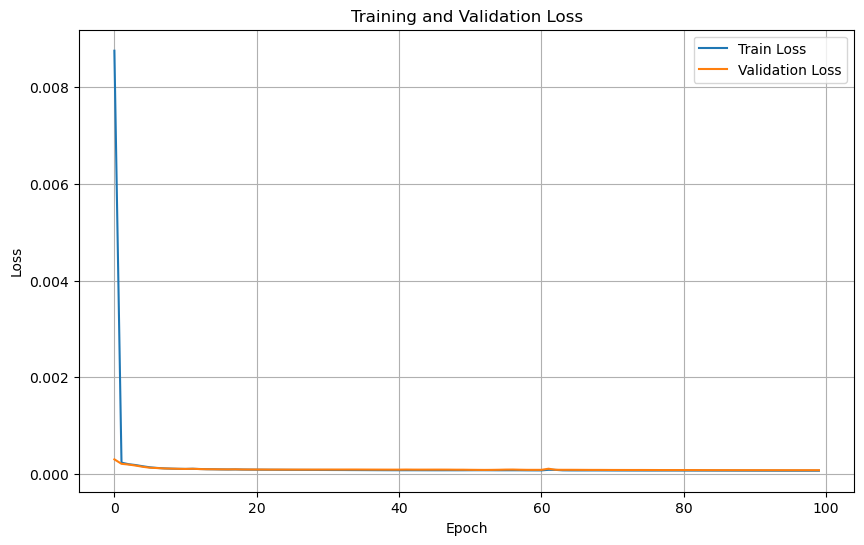

In [6]:
def main():
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # 创建数据加载器（假设你已经有了dataset）
    # train_dataset = train_dataset # 你的数据集
    # val_dataset = val_dataset
    
    # train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
    # val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
    
    # 创建模型
    model = SphericalHarmonics1DCNN(input_vars=17, output_vars=5, sph_coeffs=16471)
    
    # 检查模型参数数量
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total parameters: {total_params:,}')
    print(f'Trainable parameters: {trainable_params:,}')
    
    # 开始训练
    train_losses, val_losses = train_model(
        model, train_dataset, val_dataset, 
        num_epochs=100, device=device
    )
    
    import matplotlib.pyplot as plt
    # 绘制损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curve.png')
    plt.show()

main()

In [9]:
# 可视化函数
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import spharm
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from UNet import UNet
import torch

now_filename = "best_model.pth"
# 模型结构与加载
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SphericalHarmonics1DCNN().to(device)
# print(device)
checkpoint = torch.load(now_filename, map_location=device)
print(now_filename)
# model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

def resplot(var, variablename, titlename, cmap, extend, save=False, savepath='D://DL//train//', n_keep=None):
    """
    绘图函数，支持球谐滤波。
    - var: 输入变量，shape = (361, 720)，纬向从北到南，经向从0到360
    - n_keep: 球谐保留的最大 mode 数；若为 None 则不滤波
    """
    
    # 开始绘图
    fig = plt.figure(figsize=(12, 8))
    proj = ccrs.PlateCarree(central_longitude=180)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.6], projection=proj)
    ax.set_global()
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

    lon, lat = np.linspace(0, 360, var.shape[1]), np.linspace(90, -90, var.shape[0])
    x, y = np.meshgrid(lon - 180, lat)

    # 设置等值线级别
    if variablename == 'gh':
        levels = np.arange(0, 31, 2)
    elif variablename == 't':
        levels = np.arange(0, 3.5, 0.5)
    elif variablename == 'r':
        levels = np.arange(0, 40, 5)
    elif variablename in ['u', 'v']:
        levels = np.arange(0, 11, 2)
    else:
        levels = None

    if titlename == 'Difference':
        levels = None

    c = ax.contourf(x, y, var, levels=levels, cmap=cmap, extend=extend, transform=ccrs.PlateCarree())
    plt.colorbar(c, ax=ax, orientation="vertical", shrink=0.75)
    plt.title(f"{variablename} {titlename}")

    if save:
        savefile = f"{savepath}{variablename}_{titlename.replace(' ', '_').replace('(', '').replace(')', '')}.png"
        plt.savefig(savefile, bbox_inches='tight')

    plt.show()

from grbdata import grbdata
# 预测函数（使用 grbdata 函数）
def predict_new_file(ctrl_path_00, ctrl_path_06, spr_path, layer, model, plot_diff=True):
    data_ctrl, data_spread = grbdata(ctrl_path_00, ctrl_path_06, spr_path, layer)

    ctrl_vars = ['gh','t','r','u','v','gh_diff','t_diff','r_diff','u_diff','v_diff','gh_grad','t_grad','r_grad','u_grad','v_grad','div_ctrl','vor_ctrl']
    spread_vars = ['gh', 't', 'r', 'u', 'v']

    X = np.stack([data_ctrl[k] for k in ctrl_vars], axis=0)
    Y = np.stack([data_spread[k] for k in spread_vars], axis=0)

    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        Y_pred = model(X_tensor).squeeze(0).cpu().numpy()

    for i, varname in enumerate(spread_vars):
        resplot(Y[i], varname, "True Spread", cmap="Blues", extend="max")
        resplot(Y_pred[i], varname, "Predicted Spread", cmap="Blues", extend="max")
        n_keep = int(1e4)
        resplot(Y[i], varname, "True Spread", cmap="Blues", extend="max",n_keep = n_keep)
        # resplot(Y_pred[i], varname, "Predicted Spread", cmap="Blues", extend="max",n_keep = n_keep)
        if plot_diff:
            resplot((Y[i] - Y_pred[i])/Y[i], varname, "Difference", cmap="Reds", extend="both")
            resplot((Y[i] - Y_pred[i])/Y[i], varname, "Difference", cmap="Reds", extend="both",n_keep = n_keep)
            continue

test_date = 20250609

ctrl_test_00 = f'D:\DL\data_train\{test_date}_gec00_f000.grb2'
ctrl_test_06 = f'D:\DL\data_train\{test_date}_gec00_f006.grb2'
spr_test = f"D:\DL\data_spread\{test_date}_gespr_f006.grb2"

ctrl_test_00 = f'D:\DL\gefs\ctrl\gec00.t00z.pgrb2a.0p50.f000.grb2'
ctrl_test_06 = f'D:\DL\gefs\ctrl\gec00.t00z.pgrb2a.0p50.f006.grb2'
spr_test = f'D:\DL\gefs\spr\gespr.t00z.pgrb2a.0p50.f006.grb2'

# 调用预测
predict_new_file(ctrl_test_00, ctrl_test_06, spr_test, 500, model, plot_diff = 1)

best_model.pth


RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [1, 17, 181, 360]